## Demonstrating the SupplyComponent Class
This notebook demonstrates how to use the `SupplyComponent` class for scenario building in energy systems. We will showcase supply scenarios with:\
(a) Basic conversion technologies (fossil fuel plants)\
(b) Technologies with residual capacity\
(c) Resource technologies (e.g. renewables) with capacity factors and availability factors\
(d) Multi-mode technologies (CHP, fuel-switching) - (NOT YET IMPLEMENTED)

### 1. Import and Setup
First, import the class and set up a clean output directory for the demonstration.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.pardir)))

import numpy as np # for random number generation
np.random.seed(42)

### 2. Scenario Setup

In [2]:
import shutil
from pyoscomp.scenario.components.base import ScenarioComponent
from pyoscomp.scenario.components.supply import SupplyComponent

# Set up a clean demo output directory
DEMO_DIR = "demo_output/supply_component"
if os.path.exists(DEMO_DIR):
    shutil.rmtree(DEMO_DIR)
os.makedirs(DEMO_DIR, exist_ok=True)

In [3]:
# Common parameters for all scenarios
regions = ["North", "South", "East", "West"]
fuels = ["ELEC", "HEAT", "GAS_NAT", "COAL", "SOLAR_RESOURCE", "WIND_RESOURCE"]

### 3. Scenario 1: Basic Conversion Technologies
Demonstrates
- `add_technology()` - register technologies with operational life
- `set_conversion_technology()` - define simple fuel conversion (power plants)
- basic save/load workflow

In [4]:
# --- Scenario 1: Basic Conversion Technologies ---
scenario1_dir = os.path.join(DEMO_DIR, "scenario1")
os.makedirs(scenario1_dir, exist_ok=True)

# Copy time component prerequisite from existing scenario (see demo.time.ipynb)
ScenarioComponent.copy("demo_output/time_component/uniform", scenario1_dir, overwrite=True)

# Copy topology component prerequisite from existing scenario (see demo.topology.ipynb)
ScenarioComponent.copy("demo_output/topology_component/custom", scenario1_dir, overwrite=False)

scenario1 = SupplyComponent(scenario1_dir)
# Define basic conversion technologies for each region
for region in regions:
    
    # Coal Power Plant
    if np.random.rand() > 0.25:
        scenario1.add_technology(region, 'COAL_PP', operational_life=np.random.randint(5, 30))
        scenario1.set_conversion_technology( # set static efficiency across time
            region, 'COAL_PP', input_fuel='COAL', output_fuel='ELEC', efficiency=0.35
        )

    # Natural Gas Combined Cycle Gas Turbine
    if np.random.rand() > 0.25:
        scenario1.add_technology(region, 'GAS_CCGT', operational_life=np.random.randint(5, 30))
        scenario1.set_conversion_technology( # set time-varying efficiency
            region, 'GAS_CCGT', input_fuel='GAS_NAT', output_fuel='ELEC',
            efficiency={2020: 0.55, 2030: 0.58, 2040: 0.61}
            # (implicitly performs step interpolation between years)
        )

    # Gas Boiler for Heat
    scenario1.add_technology(region, 'GAS_BOILER', operational_life=np.random.randint(5, 30))
    scenario1.set_conversion_technology( # set different output fuel
        region, 'GAS_BOILER', input_fuel='GAS_NAT', output_fuel='HEAT', efficiency=0.9
    )

# Process and save the scenario
scenario1.process()
scenario1.save()

# Display the generated DataFrames
# Display results
print("=== Scenario 1: Basic Conversion Technologies ===")
print("\nOperational Life:")
print(scenario1.operational_life.head(10))
print("\nInput Activity Ratios:")
print(scenario1.input_activity_ratio.head(10))
print("\nOutput Activity Ratios:")
print(scenario1.output_activity_ratio.head(10))

=== Scenario 1: Basic Conversion Technologies ===

Operational Life:
  REGION  TECHNOLOGY  VALUE
0  North     COAL_PP     19
1  North    GAS_CCGT     25
2  North  GAS_BOILER     11
3  South     COAL_PP     27
4  South  GAS_BOILER     28
5   East     COAL_PP     12
6   East    GAS_CCGT     26
7   East  GAS_BOILER     25
8   West     COAL_PP     16
9   West    GAS_CCGT      6

Input Activity Ratios:
  REGION TECHNOLOGY     FUEL MODE_OF_OPERATION  YEAR     VALUE
0  North    COAL_PP     COAL             MODE1  2025  2.857143
1  North    COAL_PP     COAL             MODE1  2030  2.857143
2  North    COAL_PP     COAL             MODE1  2035  2.857143
3  North    COAL_PP     COAL             MODE1  2040  2.857143
4  North    COAL_PP     COAL             MODE1  2045  2.857143
5  North    COAL_PP     COAL             MODE1  2050  2.857143
6  North   GAS_CCGT  GAS_NAT             MODE1  2025  1.818182
7  North   GAS_CCGT  GAS_NAT             MODE1  2030  1.724138
8  North   GAS_CCGT  GAS_NAT    

### 4. Scenario 2: Technologies with Residual Capacity
Demonstrates
- `set_residual_capacity()` - represent existing (legacy) capacity, not subject to new investment

In [5]:
# --- Scenario 2: Technologies with Residual Capacity ---
scenario2_dir = os.path.join(DEMO_DIR, "scenario2")
os.makedirs(scenario2_dir, exist_ok=True)

# Copy from scenario 1 as base
ScenarioComponent.copy(scenario1_dir, scenario2_dir, overwrite=True)

scenario2 = SupplyComponent(scenario2_dir)
scenario2.load()

for i, region in enumerate(regions):
    if (region, 'COAL_PP') in scenario2.defined_tech:
        scenario2.set_residual_capacity(
            region, 'COAL_PP',
            capacity_trajectory={2025: np.random.randint(5,20), 2040: 0}, interpolation='linear')

    if (region, 'GAS_CCGT') in scenario2.defined_tech:
        scenario2.set_residual_capacity(
            region, 'GAS_CCGT',
            {2025: 8, 2025+5*i: np.random.randint(0,5), 2050: 0}, interpolation='step')

    if (region, 'GAS_BOILER') in scenario2.defined_tech:
        scenario2.set_residual_capacity(region, 'GAS_BOILER', {2025: np.random.randint(1,5)})

# Process and save the scenario
scenario2.process()
scenario2.save()

# Display the generated DataFrames
# Display results
print("=== Scenario 2: Technologies with Residual Capacity ===")
print("\nResidual Capacity:")
print(scenario2.residual_capacity.head(10))

=== Scenario 2: Technologies with Residual Capacity ===

Residual Capacity:
  REGION TECHNOLOGY  YEAR     VALUE
0  North    COAL_PP  2025  5.000000
1  North    COAL_PP  2030  3.333333
2  North    COAL_PP  2035  1.666667
3  North    COAL_PP  2040  0.000000
4  North    COAL_PP  2045  0.000000
5  North    COAL_PP  2050  0.000000
6  North   GAS_CCGT  2025  3.000000
7  North   GAS_CCGT  2030  3.000000
8  North   GAS_CCGT  2035  3.000000
9  North   GAS_CCGT  2040  3.000000


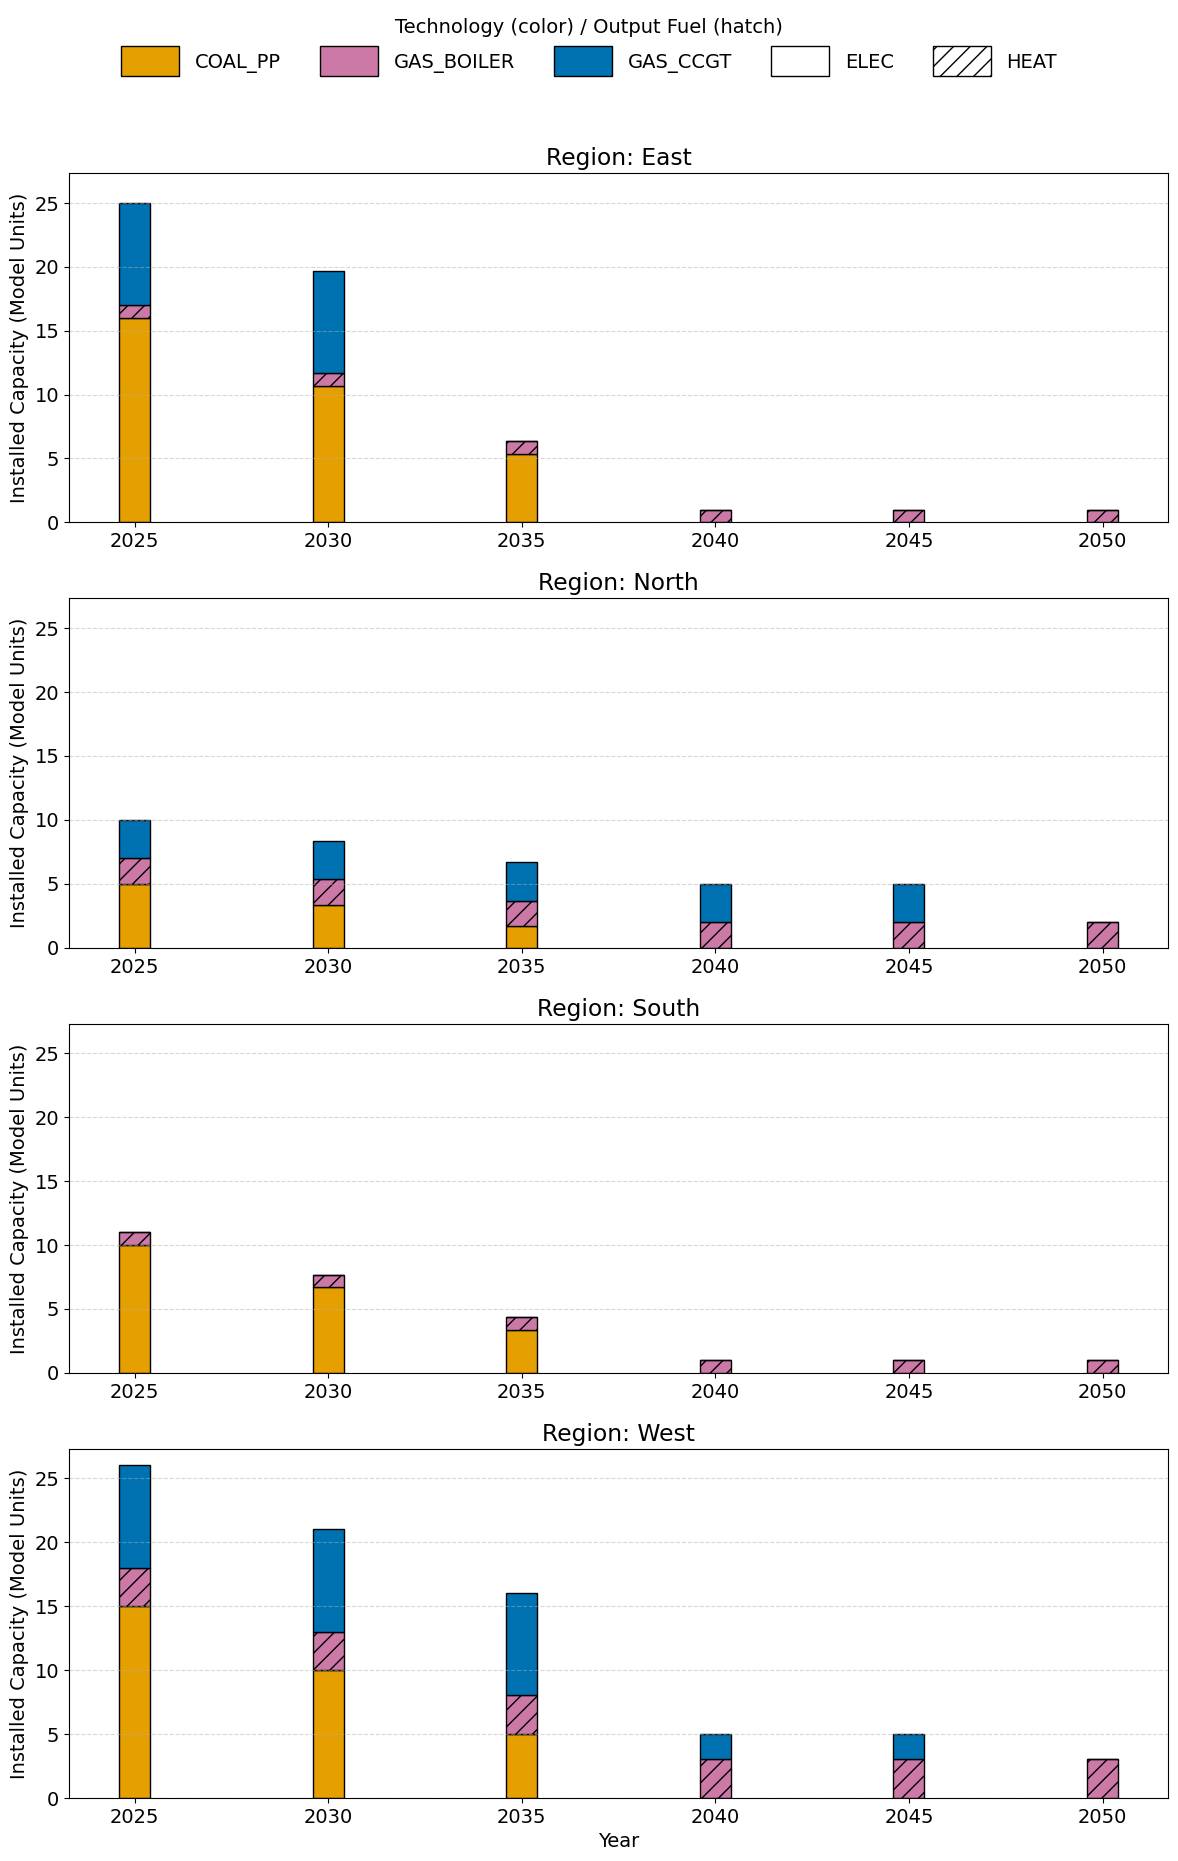

In [6]:
scenario2.visualize_capacity_mix()

### 5. Scenario 3: Resource Technologies with Capacity Factors
Demonstrates
- `set_resource_technology()` - register technologies without input fuel
- `set_capacity_factor()` - timeslice-varying capacity factors
- `set_availability_factor()` - annually varying availability factors

In [7]:
# --- Scenario 3: Resource Technologies with Capacity Factors ---
scenario3_dir = os.path.join(DEMO_DIR, "scenario3")
os.makedirs(scenario3_dir, exist_ok=True)

# Copy from scenario 2 as base
ScenarioComponent.copy(scenario2_dir, scenario3_dir, overwrite=True)

scenario3 = SupplyComponent(scenario3_dir)
scenario3.load()

for i, region in enumerate(regions):
    # Onshore Wind
    if np.random.rand() < 0.25:
        scenario3.add_technology(region, 'WIND_ONSHORE', operational_life=20) # register technology
        scenario3.set_resource_technology(region, 'WIND_ONSHORE', output_fuel='ELEC') # set as resource technology
        scenario3.set_capacity_factor( # set capacity factor profile using season_factor
            region, 'WIND_ONSHORE', season_factor = {'Winter': 0.45, 'Summer': 0.25}
        )
        scenario3.set_availability_factor( # set static availability factor
            region, 'WIND_ONSHORE', availability=0.95
        )

    # Solar Photovoltaics
    if np.random.rand() < 0.25:
        scenario3.add_technology(region, 'SOLAR_PV', operational_life=25)
        scenario3.set_resource_technology(region, 'SOLAR_PV', output_fuel='ELEC')
        scenario3.set_capacity_factor( # set capacity factor profile using time_factor
            region, 'SOLAR_PV', time_factor = {'Day': 0.3, 'Night': 0.0}
        )
        
    if (region, 'COAL_PP') in scenario3.defined_tech:
        # set time-varying availability factor
        # (implicitly performs step interpolation between years)
        coal_availability = {2025: 0.9, 2035: 0.8, 2045: 0.75}
        scenario3.set_availability_factor(region, 'COAL_PP', availability=coal_availability)

# Process and save
scenario3.process()
scenario3.save()

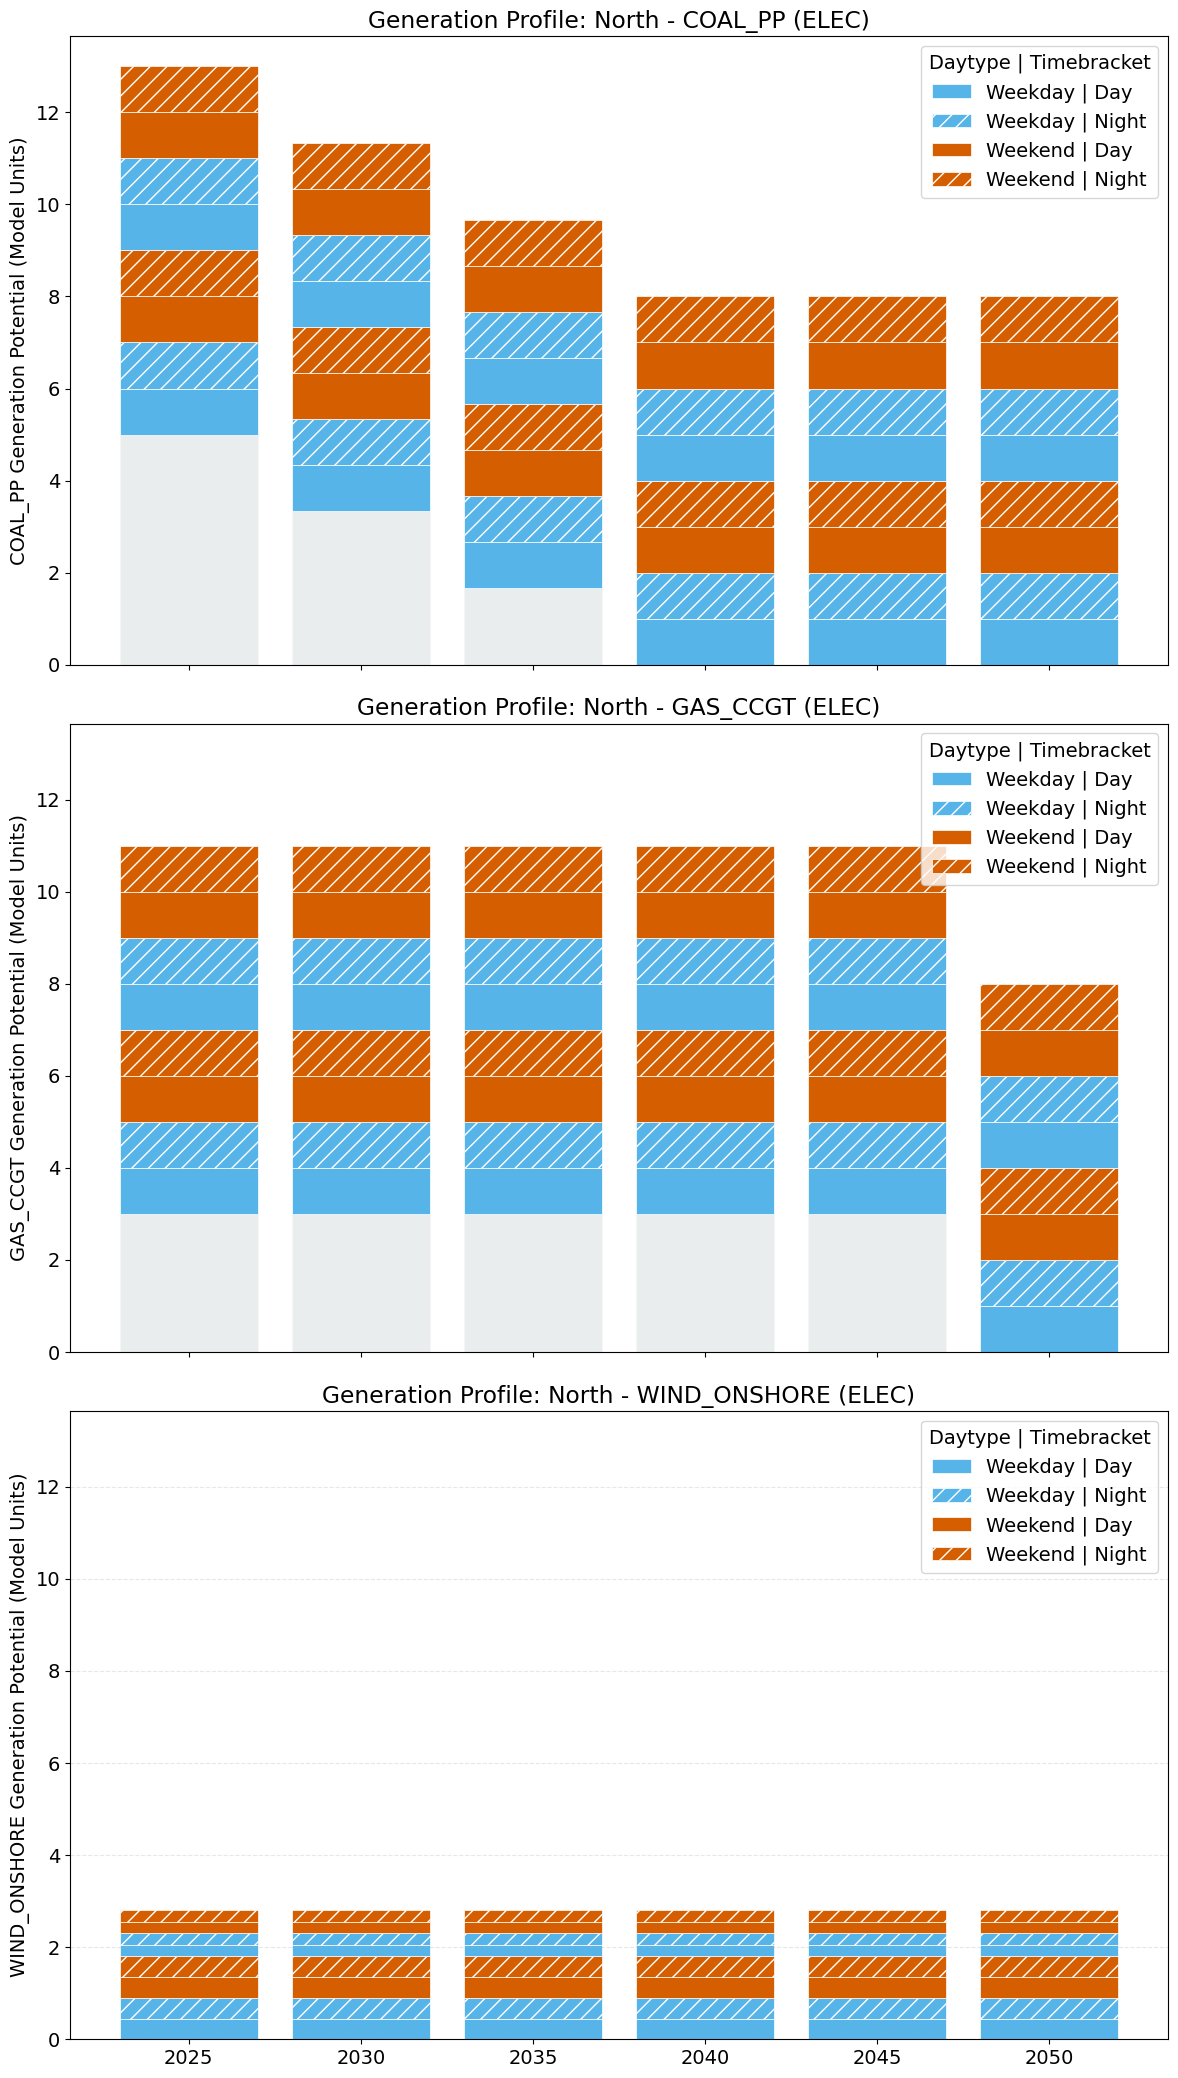

In [8]:
# shows fraction of capacity that is both available 
# and expected to be producing at each timeslice
scenario3.visualize_potential(region='North', fuel='ELEC')

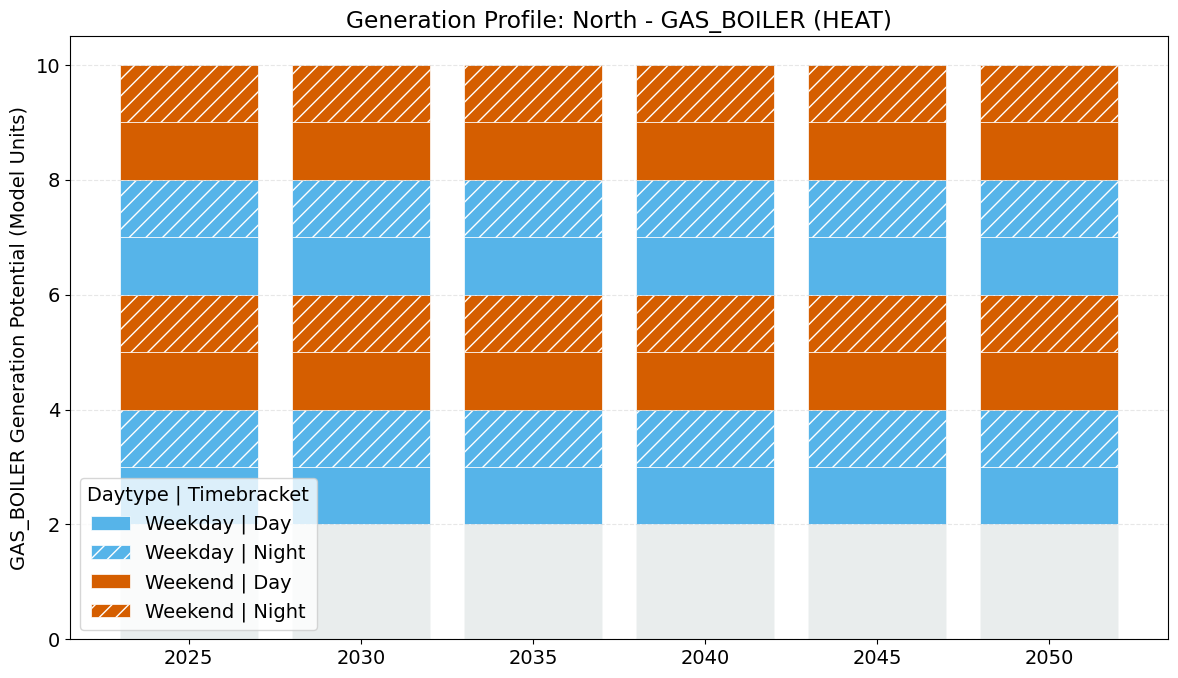

In [9]:
scenario3.visualize_potential(region='North', fuel='HEAT')

### 6. Scenario 4: Multi-mode Technologies (TODO: CHECK IMPLEMENTATION)
Demonstrates
- `set_multimode_technology()` - specify mode input and output fuels, activity ratios, and (optionally) efficiencies

In [10]:
# # --- Scenario 4: Multi-mode Technologies ---
# scenario4_dir = os.path.join(DEMO_DIR, "scenario4")
# os.makedirs(scenario4_dir, exist_ok=True)

# # Copy from scenario 1 as base
# ScenarioComponent.copy(scenario1_dir, scenario4_dir, overwrite=True)

# scenario4 = SupplyComponent(scenario4_dir)
# scenario4.load()

# modes_config = {
#     'MODE1': {
#         'inputs': {'GAS': 1.0},
#         'outputs': {'ELEC': 0.4, 'HEAT': 0.5},
#         'efficiency': 0.85
#     },
#     'MODE2': {
#         'inputs': {'GAS': 1.0},
#         'outputs': {'ELEC': 0.6, 'HEAT': 0.2},
#         'efficiency': 0.78
#     }
# }

# for i, region in enumerate(regions):
#     if np.random.rand() > 0.1:
#         scenario3.add_technology(region, 'GAS_CHP', operational_life=20)
#         scenario3.set_multimode_technology(
#             region, 'GAS_CHP', modes_config
#         )

# # Process and save
# scenario4.process()
# scenario4.save()